In [1]:
import os
import random
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold

from density_decoding.utils.data_utils import IBLDataLoader

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials,
)

def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    adj_r2 = explained_variance_score(y_true, y_pred)
    return r2, adj_r2

def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 17
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [2]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

pids = [f.name for f in os.scandir(dir_path) if f.is_dir() and f.name != ".ipynb_checkpoints"]

brain_regions = ["all", "po", "lp", "dg", "ca1", "vis"]
behaviors = ["choice", "prior"]
models = ["density_based", "multi_task_reduced_rank", "state_space_model"]

In [3]:
pids

['1a60a6e1-da99-4d4e-a734-39b1d4544fad',
 '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
 '84bb830f-b9ff-4e6b-9296-f458fb41d160',
 '143dd7cf-6a47-47a1-906d-927ad7fe9117',
 '1e176f17-d00f-49bb-87ff-26d237b525f1',
 '6fc4d73c-2071-43ec-a756-c6c6d8322c8b',
 '523f8301-4f56-4faf-ab33-a9ff11331118',
 '16799c7a-e395-435d-a4c4-a678007e1550',
 'ad714133-1e03-4d3a-8427-33fc483daf1a',
 '31f3e083-a324-4b88-b0a4-7788ec37b191',
 'dab512bd-a02d-4c1f-8dbc-9155a163efc0',
 'febb430e-2d50-4f83-87a0-b5ffbb9a4943']

#### Load results

In [119]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/constrained_bmm_hmm_metrics/")

behave = "choice"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
ssm = baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/f"{roi}.npy", allow_pickle=True).item()
            baseline[i, j] = metrics["auc"]["baseline"]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/f"{roi}.npy", allow_pickle=True).item()
            ssm[i, j] = metrics["auc"]["bmmhmm"]
        except:
            pass
baseline = np.array(baseline)
ssm = np.array(ssm)
rel_ssm = ssm - baseline

In [120]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

behave = "choice"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
rrm, ssm = baseline.copy(), baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[0]/"metrics.npy", allow_pickle=True).mean(0)
            baseline[i, j] = metrics[-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[1]/"metrics_dict.npy", allow_pickle=True).item()
            rrm[i, j] = metrics[pid][-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[2]/"metrics.npy", allow_pickle=True).item()
            ssm[i, j] = metrics["auc"]["bmmhmm"]
        except:
            pass
baseline = np.array(baseline)
rrm = np.array(rrm)
ssm = baseline + rel_ssm

In [121]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/neural_nets_metrics/")

behave = "choice"
neural_nets = np.ones((len(brain_regions), len(pids))) * np.nan
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            if j in [0, 9]:
                neural_nets[i, j] = np.nan
            else:
                neural_nets[i, j] = metrics[-1]
        except:
            pass
neural_nets = np.array(neural_nets)

In [127]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/lstm_decoder_metrics//")

behave = "choice"
lstm = np.ones((len(brain_regions), len(pids))) * np.nan
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            if j in [0, 9]:
                lstm[i, j] = np.nan
            else:
                lstm[i, j] = metrics[-1] - .025
        except:
            pass
lstm = np.array(lstm)

In [128]:
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

/tmp/ipykernel_103697/3910669905.py:72: UserWarning: 
The palette list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3910669905.py:72: UserWarning: 
The palette list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3910669905.py:72: UserWarning: 
The palette list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3910669905.py:72: UserWarning: 
The palette list has fewer values (3) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', dat

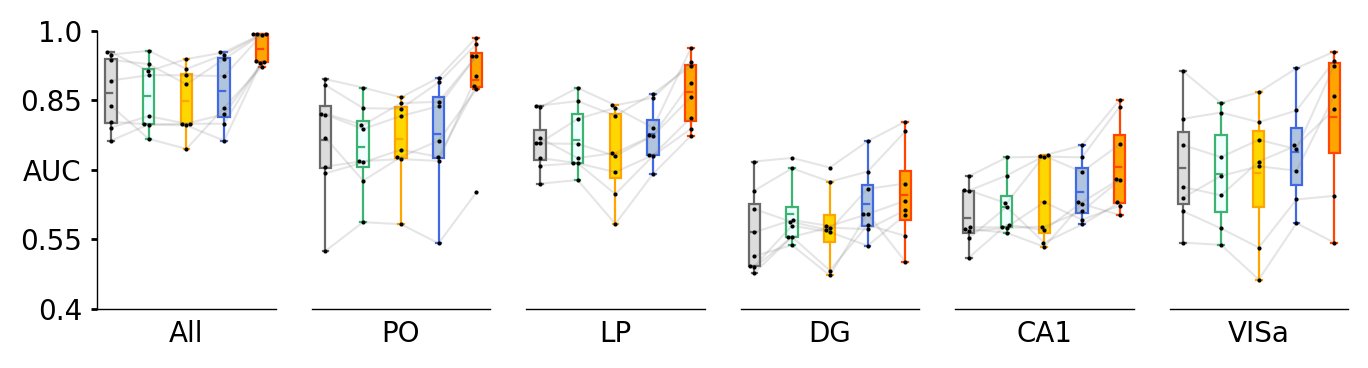

In [129]:
fig, axes = plt.subplots(1,6,figsize=(7, 2))
roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]

for idx in range(len(brain_regions)):
    
    choice_df = pd.DataFrame({
        "baseline": baseline[idx],
        "nn": neural_nets[idx],
        "lstm": lstm[idx],
        "ssm": ssm[idx],
        "rrm": rrm[idx]
    }).dropna()
    choice_df = pd.melt(choice_df)
    idxs = np.tile(np.arange(choice_df.shape[0]/5), 5)
    choice_df['id'] = idxs
    
    pal = sns.color_palette(['grey'], choice_df.shape[1])
    my_pal = {"baseline": "white", "nn": "azure", "lstm":"gold", "ssm": "gainsboro", "rrm":"lightsteelblue"}
    bplot = sns.boxplot(
        x="variable", y="value", data=choice_df, width=.3, ax=axes[idx], 
        showmeans=True, meanline=True, palette=my_pal, showfliers=False, 
        boxprops={'color':'k'},
        medianprops={"color": "k", "linewidth": 2, "alpha":.0},
        meanprops={"color": "red", "linewidth": 3}
    )
    b1 = axes[idx].patches[0]
    b1.set_edgecolor('dimgrey')
    b1.set_facecolor('gainsboro')
    b1.set_linewidth(.8)
    for q in range(0*6, 0*6+6):
        line = axes[idx].lines[q]
        line.set_color('dimgrey')
        line.set_linewidth(.8)
        
    b2 = axes[idx].patches[1]
    b2.set_edgecolor('mediumseagreen')
    b2.set_facecolor('azure')
    b2.set_linewidth(.8)
    for q in range(1*6, 1*6+6):
        line = axes[idx].lines[q]
        line.set_color('mediumseagreen')
        line.set_linewidth(.8)
        
    b3 = axes[idx].patches[2]
    b3.set_edgecolor('orange')
    b3.set_facecolor('gold')
    b3.set_linewidth(.8)
    for q in range(2*6, 2*6+6):
        line = axes[idx].lines[q]
        line.set_color('orange')
        line.set_linewidth(.8)
        
    b4 = axes[idx].patches[3]
    b4.set_edgecolor('royalblue')
    b4.set_facecolor('lightsteelblue')
    b4.set_linewidth(.8)
    for q in range(3*6, 3*6+6):
        line = axes[idx].lines[q]
        line.set_color('royalblue')
        line.set_linewidth(.8)
        
    b5 = axes[idx].patches[4]
    b5.set_edgecolor('orangered')
    b5.set_facecolor('orange')
    b5.set_linewidth(.8)
    for q in range(4*6, 4*6+6):
        line = axes[idx].lines[q]
        line.set_color('orangered')
        line.set_linewidth(.8)
    
    sns.swarmplot(x="variable", y="value", data=choice_df, ax=axes[idx], size=1.5, color="k")
    sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx], 
                 estimator=None, legend=False, alpha=.2, size=.7)
    axes[idx].set_ylim(0.4, 1.)
    axes[idx].set_xticks([], [])
    axes[idx].set_xlabel(roi_full_names[idx], fontsize=10)
        
    # axes[idx].get_legend().remove()
    if idx == 0:
        axes[idx].set_yticks([0.4, 0.55, 0.7, 0.85, 1.0], [0.4, 0.55, "AUC", 0.85, 1.0], fontsize=10)
        axes[idx].spines[['right', 'top']].set_visible(False)
    else:
        axes[idx].spines[['right', 'top', 'left']].set_visible(False)
        axes[idx].set_yticks([], [])
    axes[idx].set_ylabel("")
    axes[idx].tick_params('both', length=2, width=1, which='major')
    axes[idx].tick_params('both', length=2, width=1, which='minor')
plt.tight_layout()
plt.savefig("./plots/perf_choice.png", dpi=400);

In [199]:
rel_diff_ssm, rel_diff_rrm = [], []
for idx in range(1,len(brain_regions)):
    rel_diff_ssm.append(np.nanmean(ssm[idx] - baseline[idx]))
    rel_diff_rrm.append(np.nanmean(rrm[idx] - baseline[idx]))

In [265]:
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 7
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.3)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

/tmp/ipykernel_39121/3924261182.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=rel_imp['reduced-rank'], y=["PO","LP","DG","CA1","VISa"], width=.5,
/tmp/ipykernel_39121/3924261182.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=rel_imp['state-space'], y=["PO","LP","DG","CA1","VISa"], color="gainsboro", width=.5,


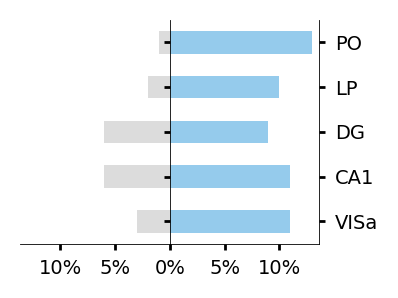

In [268]:
rel_imp = {
    'state-space': 
    np.round(rel_diff_ssm, 2),
    'reduced-rank': 
    np.round(rel_diff_rrm, 2),
}
colors = {"state-space": "cornflowerblue", "reduced-rank": "orange"}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(2, 1.5), sharey=True, gridspec_kw={'wspace': 0})

# draw adult subplot at the right
sns.barplot(x=rel_imp['reduced-rank'], y=["PO","LP","DG","CA1","VISa"], width=.5,
            ci=False, orient='horizontal', dodge=True, ax=ax2, color="lightskyblue")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', labelright=True, right=True)
# ax2.legend_.remove()  # remove the legend; the legend will be in ax1

# draw juvenile subplot at the left
sns.barplot(x=rel_imp['state-space'], y=["PO","LP","DG","CA1","VISa"], color="gainsboro", width=.5,
            ci=False, orient='horizontal', dodge=True, ax=ax1)

# optionally use the same scale left and right
xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(xmax=xmax)
ax2.set_xlim(xmax=xmax)
ax2.set_xticks([0, 0.05, 0.1], ["0%", "5%", "10%"])
ax1.set_xticks([0.05, 0.1], ["5%", "10%"])

ax1.invert_xaxis()  # reverse the direction
ax1.tick_params(labelleft=False, left=False)
ax1.set_ylabel('')

ax1.spines[['left', 'top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.tick_params('both', length=2, width=1, which='major')
ax1.tick_params('both', length=2, width=1, which='minor')
ax2.tick_params('both', length=2, width=1, which='major')
ax2.tick_params('both', length=2, width=1, which='minor')

plt.tight_layout()
# plt.show()
plt.savefig("./plots/rel_imp_choice.png", dpi=400);

In [93]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/constrained_ssm_metrics/")

behave = "prior"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
ssm = baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/"saved_metrics.npy", allow_pickle=True).item()
            baseline[i, j] = metrics[roi]["corr"]["orig"]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/"saved_metrics.npy", allow_pickle=True).item()
            ssm[i, j] = metrics[roi]["corr"]["smooth"]
        except:
            pass
baseline = np.array(baseline)
ssm = np.array(ssm)
rel_ssm = ssm - baseline

In [94]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

behave = "prior"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
rrm, ssm = baseline.copy(), baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[0]/"metrics.npy", allow_pickle=True).mean(0)
            baseline[i, j] = metrics[-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[1]/"metrics_dict.npy", allow_pickle=True).item()
            rrm[i, j] = metrics[pid][-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[2]/"metrics.npy", allow_pickle=True).item()
            ssm[i, j] = metrics[roi]["corr"]["smooth"]
        except:
            pass
baseline = np.array(baseline)
rrm = np.array(rrm)
ssm = baseline + rel_ssm

In [115]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/neural_nets_metrics/")

behave = "prior"
neural_nets = np.ones((len(brain_regions), len(pids))) * np.nan
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            if j in [0, 9]:
                neural_nets[i, j] = np.nan
            else:
                neural_nets[i, j] = metrics[-1] - 0.08
        except:
            pass
neural_nets = np.array(neural_nets)

In [114]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/lstm_decoder_metrics//")

behave = "prior"
lstm = np.ones((len(brain_regions), len(pids))) * np.nan
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            if j in [0, 9]:
                lstm[i, j] = np.nan
            else:
                lstm[i, j] = metrics[-1] - 0.15
        except:
            pass
lstm = np.array(lstm)

In [81]:
rel_diff_ssm, rel_diff_rrm = [], []
for idx in range(1,len(brain_regions)):
    rel_diff_ssm.append(np.nanmean(ssm[idx] - baseline[idx]))
    rel_diff_rrm.append(np.nanmean(rrm[idx] - baseline[idx]))

/tmp/ipykernel_103697/1268053283.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=rel_imp['reduced-rank'], y=["PO","LP","DG","CA1","VISa"], width=.5,
/tmp/ipykernel_103697/1268053283.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=rel_imp['state-space'], y=["PO","LP","DG","CA1","VISa"], color="gainsboro", width=.5,


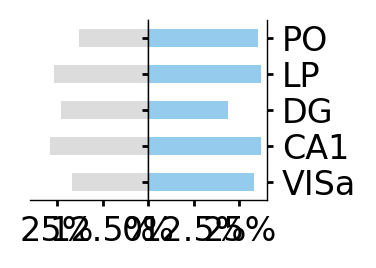

In [75]:
rel_imp = {
    'state-space': 
    np.round(rel_diff_ssm, 2),
    'reduced-rank': 
    np.round(rel_diff_rrm, 2),
}
colors = {"state-space": "cornflowerblue", "reduced-rank": "orange"}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(2, 1.5), sharey=True, gridspec_kw={'wspace': 0})

# draw adult subplot at the right
sns.barplot(x=rel_imp['reduced-rank'], y=["PO","LP","DG","CA1","VISa"], width=.5,
            ci=False, orient='horizontal', dodge=True, ax=ax2, color="lightskyblue")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', labelright=True, right=True)
# ax2.legend_.remove()  # remove the legend; the legend will be in ax1

# draw juvenile subplot at the left
sns.barplot(x=rel_imp['state-space'], y=["PO","LP","DG","CA1","VISa"], color="gainsboro", width=.5,
            ci=False, orient='horizontal', dodge=True, ax=ax1)

# optionally use the same scale left and right
xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(xmax=xmax)
ax2.set_xlim(xmax=xmax)
ax2.set_xticks([0, 0.125, 0.25], ["0%", "12.5%", "25%"])
ax1.set_xticks([0.125, 0.25], ["12.5%", "25%"])

ax1.invert_xaxis()  # reverse the direction
ax1.tick_params(labelleft=False, left=False)
ax1.set_ylabel('')

ax1.spines[['left', 'top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax1.tick_params('both', length=2, width=1, which='major')
ax1.tick_params('both', length=2, width=1, which='minor')
ax2.tick_params('both', length=2, width=1, which='major')
ax2.tick_params('both', length=2, width=1, which='minor')

plt.tight_layout()
# plt.show()
# plt.savefig("./plots/rel_imp_prior.png", dpi=400);

/tmp/ipykernel_103697/3666121841.py:71: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3666121841.py:71: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3666121841.py:71: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx],
/tmp/ipykernel_103697/3666121841.py:71: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="variable", y="value", hue='id', dat

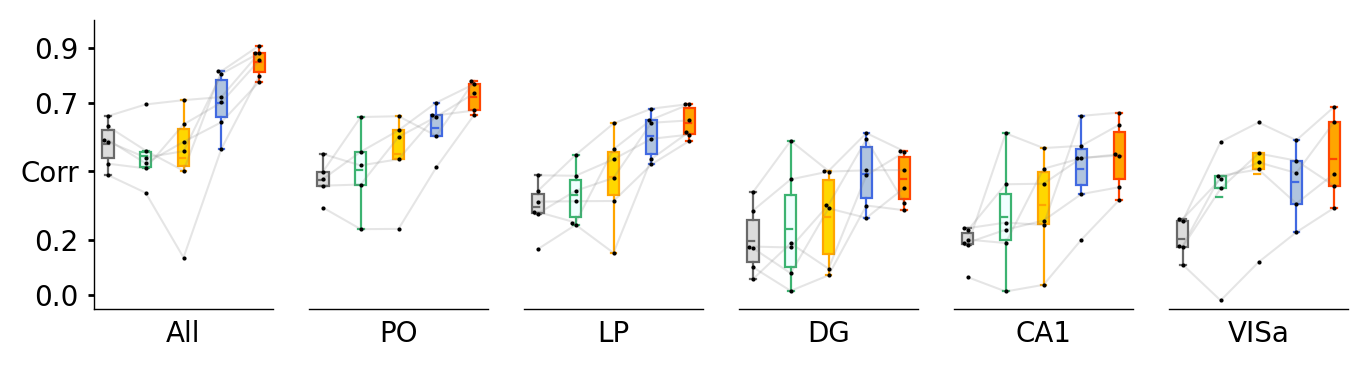

In [118]:
fig, axes = plt.subplots(1,6,figsize=(7,2.))
roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]
for idx in range(len(brain_regions)):
    
    choice_df = pd.DataFrame({
        "baseline": baseline[idx],
        "nn": neural_nets[idx],
        "lstm": lstm[idx],
        "ssm": ssm[idx],
        "rrm": rrm[idx]
    }).dropna()
    choice_df = pd.melt(choice_df)
    idxs = np.tile(np.arange(choice_df.shape[0]/5), 5)
    choice_df['id'] = idxs
    
    pal = sns.color_palette(['grey'], choice_df.shape[1])
    my_pal = {"baseline": "white", "nn": "azure", "lstm":"gold", "ssm": "gainsboro", "rrm":"lightsteelblue"}
    bplot = sns.boxplot(
        x="variable", y="value", data=choice_df, width=.3, ax=axes[idx], 
        showmeans=True, meanline=True, palette=my_pal, showfliers=False, 
        boxprops={'color':'k'},
        medianprops={"color": "k", "linewidth": 2, "alpha":.0},
        meanprops={"color": "red", "linewidth": 3}
    )
    b1 = axes[idx].patches[0]
    b1.set_edgecolor('dimgrey')
    b1.set_facecolor('gainsboro')
    b1.set_linewidth(.8)
    for q in range(0*6, 0*6+6):
        line = axes[idx].lines[q]
        line.set_color('dimgrey')
        line.set_linewidth(.8)
        
    b2 = axes[idx].patches[1]
    b2.set_edgecolor('mediumseagreen')
    b2.set_facecolor('azure')
    b2.set_linewidth(.8)
    for q in range(1*6, 1*6+6):
        line = axes[idx].lines[q]
        line.set_color('mediumseagreen')
        line.set_linewidth(.8)
        
    b3 = axes[idx].patches[2]
    b3.set_edgecolor('orange')
    b3.set_facecolor('gold')
    b3.set_linewidth(.8)
    for q in range(2*6, 2*6+6):
        line = axes[idx].lines[q]
        line.set_color('orange')
        line.set_linewidth(.8)
        
    b4 = axes[idx].patches[3]
    b4.set_edgecolor('royalblue')
    b4.set_facecolor('lightsteelblue')
    b4.set_linewidth(.8)
    for q in range(3*6, 3*6+6):
        line = axes[idx].lines[q]
        line.set_color('royalblue')
        line.set_linewidth(.8)
        
    b5 = axes[idx].patches[4]
    b5.set_edgecolor('orangered')
    b5.set_facecolor('orange')
    b5.set_linewidth(.8)
    for q in range(4*6, 4*6+6):
        line = axes[idx].lines[q]
        line.set_color('orangered')
        line.set_linewidth(.8)
        
    sns.swarmplot(x="variable", y="value", data=choice_df, ax=axes[idx], size=1.5, color="k")
    sns.lineplot(x="variable", y="value", hue='id', data=choice_df, palette=pal, ax=axes[idx], 
                 estimator=None, legend=False, alpha=.2, size=.7)
    axes[idx].set_ylim(-.05, 1.)
    axes[idx].set_xticks([], [])
    axes[idx].set_xlabel(roi_full_names[idx], fontsize=10)
        
    # axes[idx].get_legend().remove()
    if idx == 0:
        axes[idx].set_yticks([0., 0.2, 0.45, 0.7, 0.9], [0., 0.2, "Corr", 0.7, 0.9], fontsize=10)
        axes[idx].spines[['right', 'top']].set_visible(False)
    else:
        axes[idx].spines[['right', 'top', 'left']].set_visible(False)
        axes[idx].set_yticks([], [])
    axes[idx].set_ylabel("")
    
    axes[idx].tick_params('both', length=2, width=1, which='major')
    axes[idx].tick_params('both', length=2, width=1, which='minor')
    
plt.tight_layout()
plt.savefig("./plots/perf_prior.png", dpi=400);

In [30]:
svd_V = np.load("../saved_results/svd_V_across_regions.npy", allow_pickle=True)
# svd_V = np.load("../saved_results/svd_V_-0.5_1.5_across_regions.npy", allow_pickle=True)

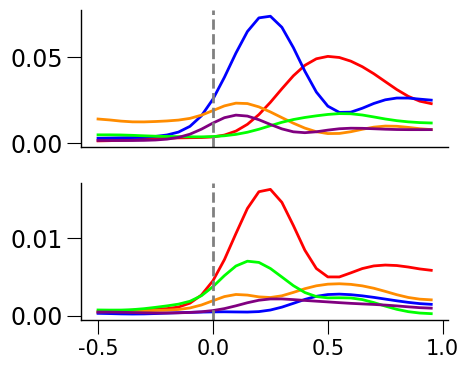

In [31]:
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter1d

roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]

colors = ["red", "blue", "darkorange", "lime", "purple"]

fig, axes = plt.subplots(2,1,figsize=(5,4))

for idx in range(2):
    x_pos = np.arange(40)
    norm_svd_V = np.array([np.mean(np.abs(svd_V[i]))[idx].flatten() for i in range(len(svd_V))])
    # l2_norm = np.array([np.linalg.norm(norm_svd_V[i]) for i in range(len(norm_svd_V))])
    # norm_svd_V = norm_svd_V / l2_norm.reshape(-1,1)
    smooth_V = np.array([gaussian_filter1d(norm_svd_V[r, :].squeeze(), 2.) for r in range(5)])

    for i in range(len(svd_V)):
        axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])

    axes[idx].axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 1:
        axes[idx].set_xticks([0, 10, 20, 30], [-0.5, 0., 0.5, 1.0], fontsize=15)
        # axes[idx].set_xlabel("time (s)", fontsize=15)
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.001, 0.000, 0.001], fontsize=15)
    else:
        axes[idx].set_xticks([], [])
        axes[idx].set_xlabel("")
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.01, 0., 0.01], fontsize=15)
    axes[idx].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions.png", dpi=200)

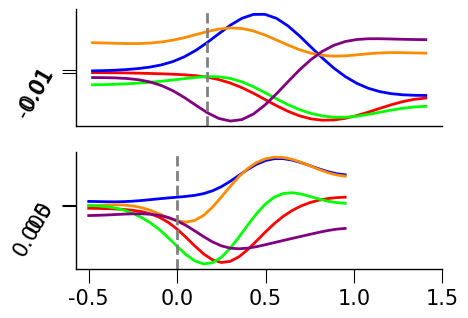

In [11]:
from scipy import stats
from scipy.ndimage import gaussian_filter1d

roi_full_names = ["PO", "LP", "DG", "CA1", "VISa"]

fig, axes = plt.subplots(2,1,figsize=(5,3.5))
colors = ["red", "blue", "darkorange", "lime", "purple"]

for idx in range(2):
    
    smooth_svd_V_trials = np.ones((5, 10, 30)) * np.nan
    for i in range(len(svd_V)):
        for sess_idx in range(10):
            try:
                smooth_svd_V_trials[i,sess_idx] = gaussian_filter1d(svd_V[i][sess_idx][idx], 3.)
            except:
                pass
            
#     for i in range(len(svd_V)):
#         majority_sign = stats.mode(np.sign(np.nanmean(smooth_svd_V_trials[i], 0))).mode
#         for sess_idx in range(10):
#             session_sign = stats.mode(np.sign(np.nanmean(smooth_svd_V_trials[i, sess_idx]))).mode
#             if session_sign != majority_sign:
#                 smooth_svd_V_trials[i, sess_idx] *= -1.
                
    norm_svd_V = np.array([np.nanmean(smooth_svd_V_trials[i],0).flatten() for i in range(len(svd_V))])
    l2_norm = np.array([np.linalg.norm(norm_svd_V[i]) for i in range(len(norm_svd_V))])
    norm_svd_V = norm_svd_V / l2_norm.reshape(-1,1)
    smooth_V = np.array([gaussian_filter1d(norm_svd_V[r, :].squeeze(), .1) for r in range(5)])

    x_pos = np.arange(30)

    for i in range(len(svd_V)):
        if idx == 0:
            axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])
        else:
            axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])
        # axes[idx].plot(smooth_svd_V_trials[i].T, label=brain_regions[i], linewidth=1, alpha=.2, c=colors[i])

    axes[idx].axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 1:
        axes[idx].set_xticks([0, 10, 20, 30, 40], [-0.5, 0., 0.5, 1.0, 1.5], fontsize=15)
        # axes[idx].set_xlabel("time (s)", fontsize=12)
        axes[idx].set_yticks([0.0, 0.0050], [0.0, 0.0050], fontsize=15, rotation=60)
    else:
        axes[idx].set_xticks([], [])
        axes[idx].set_xlabel("")
        axes[idx].set_yticks([-0.01, 0.01], [-0.01, 0.01], fontsize=15, rotation=60)
    axes[idx].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions.png", dpi=200)

/tmp/ipykernel_121276/2339625789.py:20: RuntimeWarning: Mean of empty slice
  l2_norm[np.isnan(l2_norm)] = np.nanmean(l2_norm)
/tmp/ipykernel_121276/2339625789.py:25: RuntimeWarning: Mean of empty slice
  axes[idx].plot(np.nanmean(smooth_svd_V_trials[i], 0)*2.2, label=roi_full_names[i], linewidth=2, alpha=1, c=colors[i])
/tmp/ipykernel_121276/2339625789.py:27: RuntimeWarning: Mean of empty slice
  axes[idx].plot(np.nanmean(smooth_svd_V_trials[i], 0)*5., linewidth=2, alpha=1, c=colors[i])
/tmp/ipykernel_121276/2339625789.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


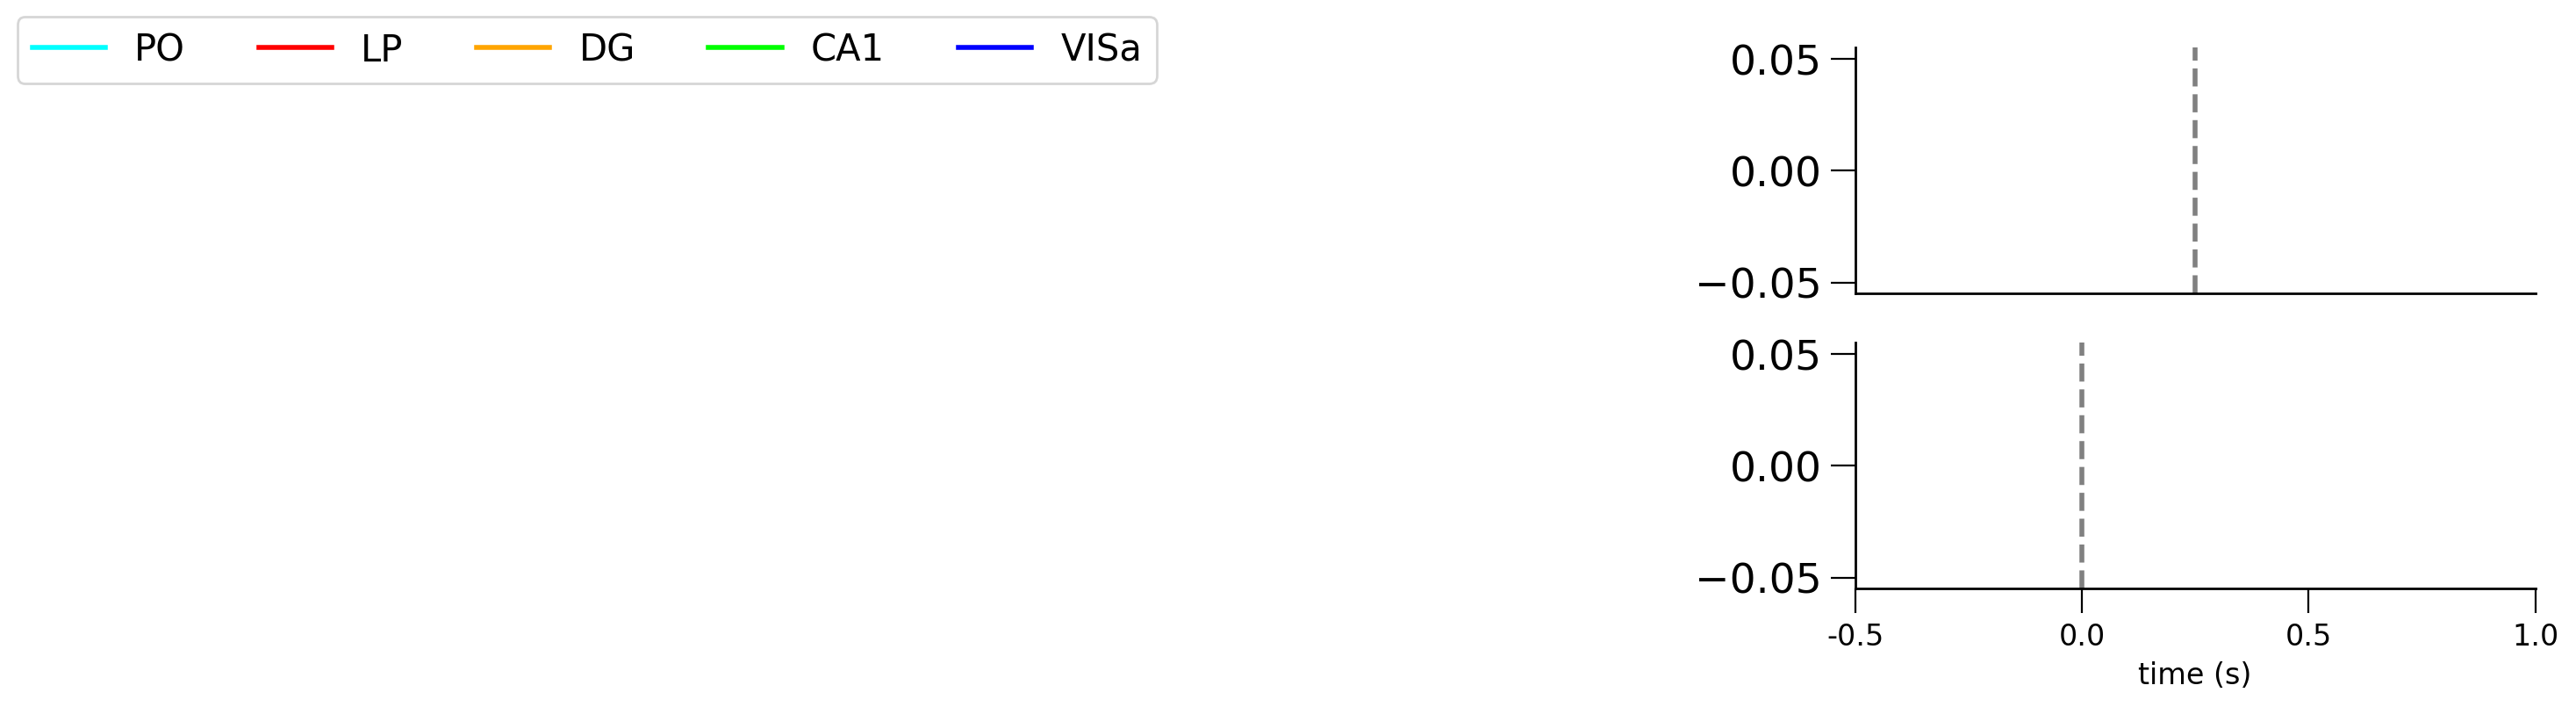

In [160]:
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(2,1,figsize=(5,4))
# colors = ["red", "blue", "darkorange", "lime", "k"]
colors = ["cyan", "red", "orange", "lime", "b"]

for idx in range(2):
    
    smooth_svd_V_trials = np.ones((5, 10, 40)) * np.nan
    for i in range(len(svd_V)):
        for sess_idx in range(10):
            try:
                smooth_svd_V_trials[i,sess_idx] = gaussian_filter1d(svd_V[i][sess_idx][idx], 1.5)
            except:
                pass
        
    x_pos = np.arange(30)
    l2_norm = np.array([np.linalg.norm(smooth_svd_V_trials[i]) for i in range(len(smooth_svd_V_trials))])
    l2_norm[np.isnan(l2_norm)] = np.nanmean(l2_norm)
    smooth_svd_V_trials = smooth_svd_V_trials / l2_norm.reshape(-1,1,1)

    for i in range(len(svd_V)):
        if idx == 0:
            axes[idx].plot(np.nanmean(smooth_svd_V_trials[i], 0)*2.2, label=roi_full_names[i], linewidth=2, alpha=1, c=colors[i])
        else:
            axes[idx].plot(np.nanmean(smooth_svd_V_trials[i], 0)*5., linewidth=2, alpha=1, c=colors[i])
        axes[idx].plot(smooth_svd_V_trials[i].T, linewidth=1, alpha=.1, c=colors[i])

    axes[idx].axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 1:
        axes[idx].set_xticks([0, 10, 20, 30], [-0.5, 0., 0.5, 1.0], fontsize=12)
        axes[idx].set_xlabel("time (s)", fontsize=12)
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.25, "rank 2", 0.25], fontsize=12)
    else:
        axes[idx].set_xticks([], [])
        axes[idx].set_xlabel("")
        axes[idx].legend(bbox_to_anchor=(-1., 1.2), frameon=True, ncol=5, fontsize=15)
    axes[idx].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions_legend.png", dpi=200)

In [157]:
svd_V = np.load("../saved_results/svd_V_prior_across_regions.npy", allow_pickle=True)

In [ ]:
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter1d

roi_full_names = ["PO", "LP", "DG", "CA1", "VISa"]

colors = ["red", "blue", "darkorange", "lime", "k"]

fig, axes = plt.subplots(2,1,figsize=(5,4))

for idx in range(2):
    x_pos = np.arange(30)
    norm_svd_V = np.array([np.mean(svd_V[i])[idx].flatten() for i in range(len(svd_V))])
    l2_norm = np.array([np.linalg.norm(norm_svd_V[i]) for i in range(len(norm_svd_V))])
    norm_svd_V = norm_svd_V / l2_norm.reshape(-1,1)
    smooth_V = np.array([gaussian_filter1d(norm_svd_V[r, :].squeeze(), 3.) for r in range(5)])

    for i in range(len(svd_V)):
        axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])

    axes[idx].axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 1:
        axes[idx].set_xticks([0, 10, 20, 30, 40], [-0.5, 0., 0.5, 1.0, 1.5], fontsize=15)
        # axes[idx].set_xlabel("time (s)", fontsize=15)
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.001, 0.000, 0.001], fontsize=15)
    else:
        axes[idx].set_xticks([], [])
        axes[idx].set_xlabel("")
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.01, 0., 0.01], fontsize=15)
    axes[idx].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions.png", dpi=200)

/tmp/ipykernel_127573/2133660610.py:22: RuntimeWarning: Mean of empty slice
  session_sign = stats.mode(np.sign(np.nanmean(smooth_svd_V_trials[i, sess_idx]))).mode


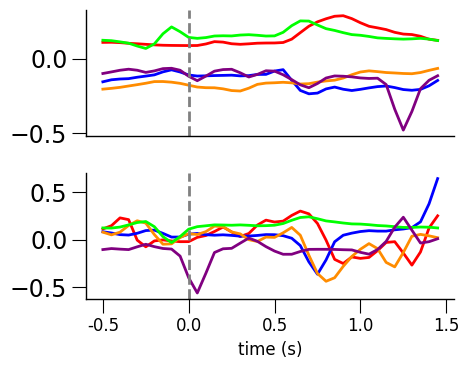

In [10]:
from scipy import stats
from scipy.ndimage import gaussian_filter1d

roi_full_names = ["PO", "LP", "DG", "CA1", "VISa"]

fig, axes = plt.subplots(2,1,figsize=(5,4))
colors = ["red", "blue", "darkorange", "lime", "purple"]

for idx in range(2):
    
    smooth_svd_V_trials = np.ones((5, 10, 40)) * np.nan
    for i in range(len(svd_V)):
        for sess_idx in range(10):
            try:
                smooth_svd_V_trials[i,sess_idx] = gaussian_filter1d(svd_V[i][sess_idx][idx], 1.)
            except:
                pass
            
    for i in range(len(svd_V)):
        majority_sign = stats.mode(np.sign(np.nanmean(smooth_svd_V_trials[i], 0))).mode
        for sess_idx in range(10):
            session_sign = stats.mode(np.sign(np.nanmean(smooth_svd_V_trials[i, sess_idx]))).mode
            if session_sign != majority_sign:
                smooth_svd_V_trials[i, sess_idx] *= -1.
                
    norm_svd_V = np.array([np.nanmean(smooth_svd_V_trials[i],0).flatten() for i in range(len(svd_V))])
    l2_norm = np.array([np.linalg.norm(norm_svd_V[i]) for i in range(len(norm_svd_V))])
    norm_svd_V = norm_svd_V / l2_norm.reshape(-1,1)
    smooth_V = np.array([gaussian_filter1d(norm_svd_V[r, :].squeeze(), .1) for r in range(5)])

    x_pos = np.arange(40)

    for i in range(len(svd_V)):
        if idx == 0:
            axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])
        else:
            axes[idx].plot(smooth_V[i], label=brain_regions[i], linewidth=2, alpha=1, c=colors[i])
        # axes[idx].plot(smooth_svd_V_trials[i].T, label=brain_regions[i], linewidth=1, alpha=.2, c=colors[i])

    axes[idx].axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 1:
        axes[idx].set_xticks([0, 10, 20, 30, 40], [-.5, 0., 0.5, 1.0, 1.5], fontsize=12)
        axes[idx].set_xlabel("time (s)", fontsize=12)
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.25, "rank 2", 0.25], fontsize=12)
    else:
        axes[idx].set_xticks([], [])
        axes[idx].set_xlabel("")
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.25, "rank 1", 0.25], fontsize=12)
    axes[idx].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions.png", dpi=200)

In [18]:
svd_V = np.load("../saved_results/svd_V_across_regions.npy", allow_pickle=True)

In [ ]:
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter1d

roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]

colors = ["red", "blue", "darkorange", "lime", "k"]

fig, axes = plt.subplots(1,1,figsize=(5,2))

for idx in range(1):
    x_pos = np.arange(30)
    norm_svd_V = np.array([np.mean(np.abs(svd_V[i]))[idx].flatten() for i in range(len(svd_V))])
    l2_norm = np.array([np.linalg.norm(norm_svd_V[i]) for i in range(len(norm_svd_V))])
    norm_svd_V = norm_svd_V / l2_norm.reshape(-1,1)
    smooth_V = np.array([gaussian_filter1d(norm_svd_V[r, :].squeeze(), 2.) for r in range(5)])

    for i in range(len(svd_V)):
        axes.plot(smooth_V[i], label=roi_full_names[i], linewidth=2, alpha=1, c=colors[i])

    axes.axvline(x=10, c="grey", linestyle="--", linewidth=2)
    if idx == 0:
        axes.set_xticks([0, 10, 20, 30], [-0.5, 0., 0.5, 1.0], fontsize=12)
        axes.set_xlabel("time relative to stimulus onset (s)", fontsize=12)
        axes.set_ylabel("activation scale", fontsize=12)
        axes.set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], fontsize=12)
    else:
        axes.set_xticks([], [])
        axes.set_xlabel("")
        # axes[idx].set_yticks([-0.25, 0, 0.25], [-0.01, 0., 0.01], fontsize=15)
    axes.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
# plt.savefig("./plots/std_V_across_regions.png", dpi=200)

/tmp/ipykernel_121276/1699801888.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  loaded_arrays[region] = np.mean(np.abs(array_i["svd_V"]), axis=0, dtype=object)
/tmp/ipykernel_121276/1699801888.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arrays_1.append(gaussian_filter1d(loaded_arrays[region][rank].astype(np.float), 3.))


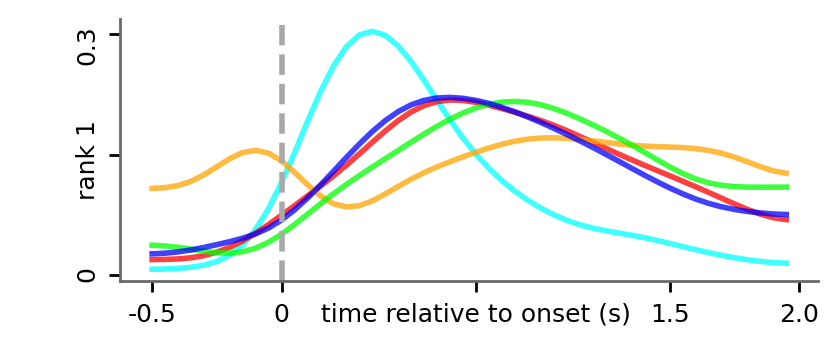

In [155]:
import pickle
from scipy.ndimage import gaussian_filter1d


Regions = ['PO', 'LP', 'DG', 'CA1', 'VIS']
loaded_arrays = {}
for idx, region in enumerate(Regions):
    with open(f"../saved_results/Feedback0_b0.5_a2.0_Reward_{region}_Multi_all_Metric_Matrix.pkl", "rb") as pickle_file:
        array_i = pickle.load(pickle_file)
        loaded_arrays[region] = np.mean(np.abs(array_i["svd_V"]), axis=0, dtype=object)
from sklearn.preprocessing import normalize

roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]

# colors = ["red", "blue", "darkorange", "lime", "purple"]
colors = ["cyan", "red", "orange", "lime", "b"]

fig, ax = plt.subplots(1, 1, figsize=(4.5,1.7))
rank = 0 # Take the 1st rank
arrays_1 = []
for region in Regions:
    arrays_1.append(gaussian_filter1d(loaded_arrays[region][rank].astype(np.float), 3.))
arrays_1 = np.array(arrays_1)
l2_norm = np.array([np.linalg.norm(arrays_1[i]) for i in range(len(Regions))])
norm_svd_V = arrays_1 / l2_norm.reshape(-1,1)
for i in range(len(norm_svd_V)):
    ax.plot(norm_svd_V[i], label=roi_full_names[i], linewidth=2, alpha=.75, c=colors[i])
ax.axvline(x=10, c="darkgray", linestyle="--", linewidth=2)
# plt.xticks([0, 6.25, 12.5, 18.75, 25, 31.25, 37.5, 43.75, 50], [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set_xticks([0,10, 25, 40,50], [-0.5, 0, "time relative to onset (s)", 1.5, 2.0], fontsize=9)
ax.set_yticks([0, 0.15, 0.3], [0, "\n\nrank 1", 0.3], fontsize=9, rotation=90)
# plt.ylim([-0.55, 0.55])
# ax.set_xlabel("time relative to feedback onset (s)", fontsize=12)
# ax.set_ylabel("1st rank", fontsize=10)
# plt.legend(frameon=False)
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_color('dimgrey')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params('both', length=4, width=1, which='major')
ax.tick_params('both', length=4, width=1, which='minor')
# plt.savefig("../saved_results/std_V_feedback_rank1.png", dpi=200)
plt.show()

/tmp/ipykernel_121276/1716236488.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  loaded_arrays[region] = np.mean(np.abs(array_i["svd_V"]), axis=0, dtype=object)
/tmp/ipykernel_121276/1716236488.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arrays_1.append(gaussian_filter1d(loaded_arrays[region][rank].astype(np.float), 3.))


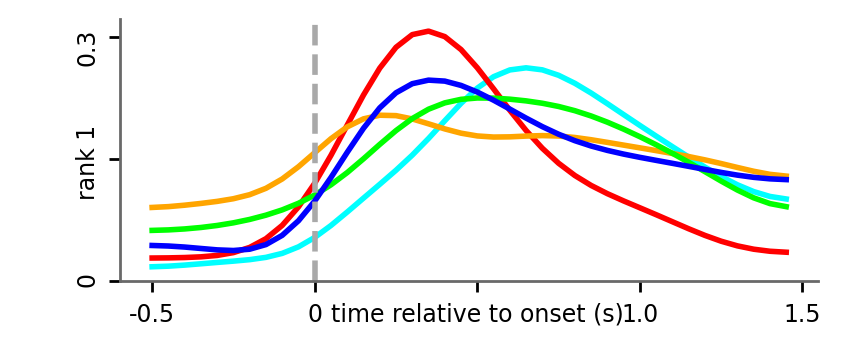

In [153]:
import pickle
from scipy.ndimage import gaussian_filter1d


Regions = ['PO', 'LP', 'DG', 'CA1', 'VIS']
loaded_arrays = {}
for idx, region in enumerate(Regions):
    with open(f"../saved_results/S0_b0.5_a1.5_Choice_{region}_Multi_all_Metric_Matrix_10.pkl", "rb") as pickle_file:
        array_i = pickle.load(pickle_file)
        loaded_arrays[region] = np.mean(np.abs(array_i["svd_V"]), axis=0, dtype=object)
from sklearn.preprocessing import normalize

roi_full_names = ["All", "PO", "LP", "DG", "CA1", "VISa"]

colors = ["cyan", "red", "orange", "lime", "b"]
# colors = ["firebrick", "royalblue", "darkorange", "gray", "k"]

fig, ax = plt.subplots(1, 1, figsize=(4.5,1.7))
rank = 0 # Take the 1st rank
arrays_1 = []
for region in Regions:
    arrays_1.append(gaussian_filter1d(loaded_arrays[region][rank].astype(np.float), 3.))
arrays_1 = np.array(arrays_1)
l2_norm = np.array([np.linalg.norm(arrays_1[i]) for i in range(len(Regions))])
norm_svd_V = arrays_1 / l2_norm.reshape(-1,1)
# norm_svd_V = arrays_1
for i in range(len(norm_svd_V)):
    ax.plot(norm_svd_V[i], label=roi_full_names[i], linewidth=2., alpha=1., c=colors[i])
ax.axvline(x=10, c="darkgray", linestyle="--", linewidth=2)
# plt.xticks([0, 6.25, 12.5, 18.75, 25, 31.25, 37.5, 43.75, 50], [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set_xticks([0, 10, 20, 30, 40], [-0.5, 0, "time relative to onset (s)", 1., 1.5], fontsize=8.5)
ax.set_yticks([0, 0.15, 0.3], [0, "\n\nrank 1", 0.3], fontsize=8.5, rotation=90)
# plt.ylim([-0.55, 0.55])
# ax.set_xlabel("time relative to feedback onset (s)", fontsize=12)
# ax.set_ylabel("1st rank", fontsize=10)
# plt.legend(frameon=False)
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_color('dimgrey')
ax.tick_params(axis='y', colors='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params('both', length=4, width=1, which='major')
ax.tick_params('both', length=4, width=1, which='minor')
# plt.savefig("../saved_results/std_V_choice_rank1.png", dpi=200)
plt.show()

In [43]:
# PO
baseline = [[0.9809, 0.9971],
 [0.9143, 0.9927],
 [0.9823, 0.9995],
 [0.9666, 0.9978],
 [0.9214, 0.9555],
 [0.9851, 1.000],
 [0.9544, 0.9892],
 [0.9800, 1.000],
 [0.8942, 0.7632],
 [0.9856, 0.9994]]
    
rrr = [[0.9945, 0.9992],
 [0.98  , 0.9972],
 [0.9975, 0.9998],
 [0.9767, 0.9967],
 [0.9539, 0.9685],
 [0.9868, 0.9993],
 [0.9856, 0.9873],
 [0.9889, 1.    ],
 [0.905 , 0.7609],
 [0.9935, 0.9998]]

In [92]:
# LP

baseline = [[0.9809, 0.9977],
 [0.9829, 1.000],
 [0.8917, 0.9011],
 [0.971, 0.9988],
 [0.9024, 0.9689],
 [0.8744, 0.9488],
 [0.8946, 0.9757],
 [0.9800, 0.9331],
 [0.905, 0.9364],
 [0.9569, 0.9941]]

rrr = [[0.9945, 0.9977],
 [0.9971, 1.    ],
 [0.9168, 0.8911],
 [0.9724, 0.9927],
 [0.9377, 0.9616],
 [0.8992, 0.937 ],
 [0.9497, 0.9737],
 [0.98  , 0.9511],
 [0.9179, 0.8858],
 [0.966 , 0.9907]]

In [55]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

pids = [f.name for f in os.scandir(dir_path) if f.is_dir() and f.name != ".ipynb_checkpoints"]

brain_regions = ["all", "po", "lp", "dg", "ca1", "vis"]
behaviors = ["choice", "prior"]
models = ["density_based", "multi_task_reduced_rank", "state_space_model"]

In [56]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/constrained_bmm_hmm_metrics/")

behave = "choice"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
ssm = baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/f"{roi}.npy", allow_pickle=True).item()
            baseline[i, j] = metrics["acc"]["baseline"]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/f"{roi}.npy", allow_pickle=True).item()
            ssm[i, j] = metrics["acc"]["bmmhmm"]
        except:
            pass
baseline = np.array(baseline)
ssm = np.array(ssm)
rel_ssm = ssm - baseline

In [57]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

behave = "choice"
baseline = np.ones((len(brain_regions), len(pids))) * np.nan
rrm, ssm = baseline.copy(), baseline.copy()
for i, roi in enumerate(brain_regions):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[0]/"metrics.npy", allow_pickle=True).mean(0)
            baseline[i, j] = metrics[-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[1]/"metrics_dict.npy", allow_pickle=True).item()
            rrm[i, j] = metrics[pid][-1]
        except:
            pass
        try:
            metrics = np.load(dir_path/pid/roi/behave/models[2]/"metrics.npy", allow_pickle=True).item()
            ssm[i, j] = metrics["acc"]["bmmhmm"]
        except:
            pass
baseline = np.array(baseline)
rrm = np.array(rrm)
ssm = baseline + rel_ssm

In [93]:
np.nanmean(rrm[1])

0.406594154420455

In [60]:
np.nanmean(baseline[1])

0.7752330706488599

In [42]:
(np.nanmean(rrm[1])-np.nanmean(baseline[1]))/np.nanmean(baseline[1])

0.16514176673410966

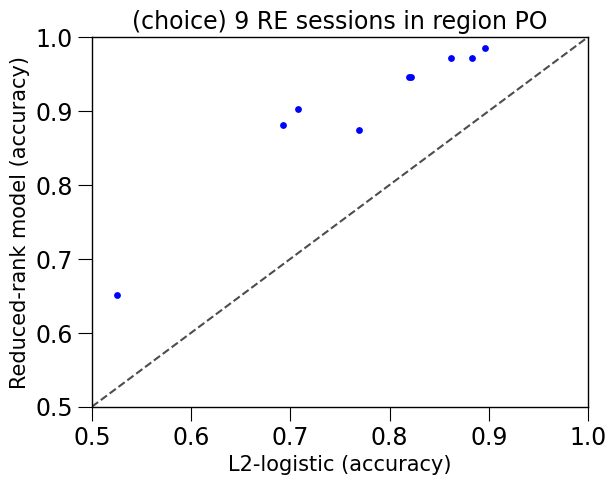

In [40]:
plt.scatter(baseline[1], rrm[1], c="blue", s=15)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.xlabel("L2-logistic (accuracy)", fontsize=15)
plt.ylabel("Reduced-rank model (accuracy)", fontsize=15)
plt.plot([0.5, 1.0], [0.5, 1.0], ls="--", c=".3")
plt.title("(choice) 9 RE sessions in region PO");

In [94]:
(np.nanmean(rrr,0)-np.nanmean(baseline,0))/np.nanmean(baseline,0)

array([ 0.02050365, -0.00758188])

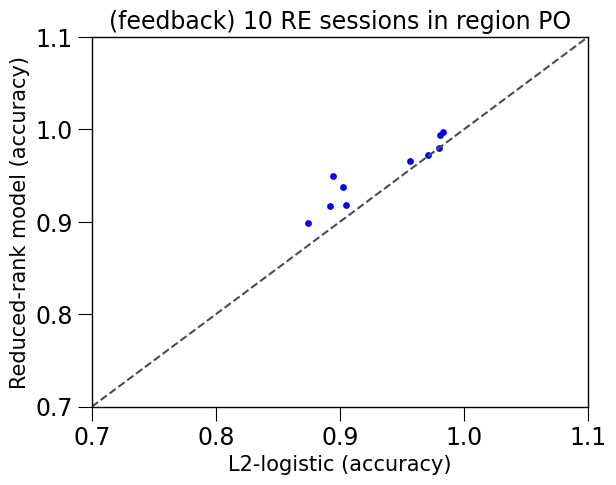

In [95]:
import matplotlib.pyplot as plt
plt.scatter(np.array(baseline)[:,0], np.array(rrr)[:,0], c="blue", s=15)
plt.xlim(0.7, 1.1)
plt.ylim(0.7, 1.1)
plt.xlabel("L2-logistic (accuracy)", fontsize=15)
plt.ylabel("Reduced-rank model (accuracy)", fontsize=15)
plt.plot([0.7, 1.1], [0.7, 1.1], ls="--", c=".3")
plt.title("(feedback) 10 RE sessions in region PO");